# Lab 8 - Integer Programming - BnB for MIP

Information on group members:

1) 156071, Martyna Stasiak <br>
2) 156062, Maria Musiał

In [161]:
from pulp import *  
import numpy as np
import pandas as pd
import heapq

1) Given is the below MIP problem. Note that the first 5 variables are of an integer type with specified upper bounds

In [162]:
def getProblem(relaxed = False):
    
    A = [
        [0,3,2,0,0,0,-3,-1,0,0],
        [1,1,0,2,0,0,0,-1,2,1],
        [0,0,2,-2,3,0,-2,2,1,0],
        [0,0,2,0,0,-1,0,0,0,1],
        [0,2,0,0,0,-2,0,0,0,1],
        [1,4,0,0,0,0,-3,6,2,0],
        [2,2,0,0,2,2,0,0,2,2],
        [0,0,3,0,-1,1,0,-1,0,1],
        [0,0,0,0,5,0,1,1,0,3],
        [2,-7,0,0,0,1,0,8,2,0]]
    b = [10,15,20,20,30,50,40,20,25,25]
    c = [5, 7, 5, 5, 5, 5, 7, 4, 9, 10]
    uB = [5, 8, 4, 5, 4, 5, 5, 3, 3, 3]
    
    problem = LpProblem(name="bnb-problem", sense=LpMaximize)
    
    ### 5 integers and 3 continuous (if relaxed, 8 cont.)
    cat = ['Integer' for i in range(5)] + ['Continuous' for i in range(5)]
    if relaxed: cat = ['Continuous' for i in range(5)] + ['Continuous' for i in range(5)]
        
    x = [LpVariable(name="x"+ str(i+1), lowBound=0, upBound=uB[i], cat = cat[i]) for i in range(10)]
    
    for r in range(10):
        expr = lpSum([x[j] * A[r][j] for j in range(10)])
        problem += LpConstraint(e=expr, sense = -1, name = "baseC"+str(r+1), rhs = b[r])
        
    obj_func = lpSum([x[j] * c[j] for j in range(10)])
    problem += obj_func
    
    return x, problem

x, P = getProblem()
print(P)

bnb-problem:
MAXIMIZE
5*x1 + 10*x10 + 7*x2 + 5*x3 + 5*x4 + 5*x5 + 5*x6 + 7*x7 + 4*x8 + 9*x9 + 0
SUBJECT TO
baseC1: 3 x2 + 2 x3 - 3 x7 - x8 <= 10

baseC2: x1 + x10 + x2 + 2 x4 - x8 + 2 x9 <= 15

baseC3: 2 x3 - 2 x4 + 3 x5 - 2 x7 + 2 x8 + x9 <= 20

baseC4: x10 + 2 x3 - x6 <= 20

baseC5: x10 + 2 x2 - 2 x6 <= 30

baseC6: x1 + 4 x2 - 3 x7 + 6 x8 + 2 x9 <= 50

baseC7: 2 x1 + 2 x10 + 2 x2 + 2 x5 + 2 x6 + 2 x9 <= 40

baseC8: x10 + 3 x3 - x5 + x6 - x8 <= 20

baseC9: 3 x10 + 5 x5 + x7 + x8 <= 25

baseC10: 2 x1 - 7 x2 + x6 + 8 x8 + 2 x9 <= 25

VARIABLES
0 <= x1 <= 5 Integer
x10 <= 3 Continuous
0 <= x2 <= 8 Integer
0 <= x3 <= 4 Integer
0 <= x4 <= 5 Integer
0 <= x5 <= 4 Integer
x6 <= 5 Continuous
x7 <= 5 Continuous
x8 <= 3 Continuous
x9 <= 3 Continuous



2) The below function returns None if the problem has no feasible solutions. Otherwise, it returns a tuple: objective function values and a vector of decision variables. 

In [163]:
def getSolution(x, problem):
    status = problem.solve()
    if problem.status != 1: return None
    return problem.objective.value(), [_.value() for _ in x]

3) PuLP can solve MIP problems. Hence, the "relaxed" flag can be set to False. Solve the problem and analyze the obtained outcome.  

In [164]:
x, problem = getProblem(relaxed = False)
print(getSolution(x, problem))

(207.0, [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0])


4) Now, compare this solution with the one obtained for the relaxed LP problem: 

In [165]:
x, problem = getProblem(relaxed = True)
print(getSolution(x, problem))

(211.33333355000002, [0.73333333, 6.6666667, 4.0, 0.8, 1.6, 5.0, 5.0, 3.0, 3.0, 3.0])


5) Your task is to implement the Branch and Bound Algorithm for solving MIP problems. You can use the PuLP library for solving the relaxed LP subproblems. <br>
<ul> 
    <li> Firstly, as a node selection policy, implement the default DFS-like strategy as shown in the lecture (generate both children in one iteration; prioritize the left children, i.e., associated with the "<=" constraint). As for the variable selection policy, take the one with the lowest index  (default, arbitrary selection). 
<li> Identify how many LP relaxed problems have to be solved to find the optimum. Note that such a number was reported to be 35 for the default policies. However, it may vary slightly for different solvers due to possible multiple sub-optima.
<li> Propose at least 3 new node and variable selection policies with the aim of minimizing the number of solver runs required to reach the optimum.  Try getting below 20. 
    </ul>

In [166]:
from collections import deque
from pulp import LpConstraint, LpVariable, lpSum
import matplotlib.pyplot as plt

<h2>Depth-First Search (DFS) Heuristic: </h2>
    This heuristic explores a branch fully before backtracking to explore other branches.
    It uses a stack (LIFO) structure to keep track of unexplored nodes, prioritizing deeper nodes.
    

In [167]:
# DFS-based Branch and Bound function
def dfs_branch_and_bound(variable_selection_policy):
    x, initial_problem = getProblem(relaxed=True)
    initial_solution = getSolution(x, initial_problem)

    if initial_solution is None:
        return None, 0

    best_solution = None
    best_obj_value = float('-inf')

    # Initialize stack for DFS
    stack = [(initial_problem, initial_solution)]

    lp_relaxations_solved = 0

    while stack:
        # Pop the last node (DFS)
        current_problem, current_solution = stack.pop()
        
        
        # print("--------------")
        # print(current_problem)
        # print("--------------")

        lp_relaxations_solved += 1
        obj_value, solution = current_solution

        # Check if the solution is better than the current best
        
            
        if obj_value < best_obj_value:
            continue

        # Find the first variable with a fractional value for branching
        branching_var_ind = None
        for idx, val in enumerate(solution):
            if val % 1 != 0:
                branching_var_ind = variable_selection_policy(solution, x, current_problem)
                break

        if branching_var_ind is None:
            if obj_value > best_obj_value:
                best_solution = solution
                best_obj_value = obj_value
                
                
        if branching_var_ind is None:
            continue
       
        
        if solution[branching_var_ind] is not None:
        # Branch by creating two subproblems
            left_problem = current_problem.copy()
            left_problem += x[branching_var_ind] <= math.floor(solution[branching_var_ind])
            # left_problem += LpConstraint(e=branching_var <= math.floor(solution[x.index(branching_var)]) , name=f"branch_left_{branching_var.name}")

            right_problem = current_problem.copy()
            right_problem += x[branching_var_ind] >= math.ceil(solution[branching_var_ind])
            # right_problem += LpConstraint(e=branching_var >= math.ceil(solution[x.index(branching_var)]), name=f"branch_right_{branching_var.name}")

            # print(left_problem)

            for new_problem in [left_problem, right_problem]:
                new_solution = getSolution(x, new_problem)
                # print("grrr")
                if new_solution:
                    stack.append((new_problem, new_solution))
                    # print("hiii")

    return best_solution, best_obj_value, lp_relaxations_solved

<h2>Breadth-First Search (BFS) Heuristic:</h2>
This heuristic explores all nodes at the current depth level before moving to deeper levels.
It uses a queue (FIFO) structure to ensure nodes are processed in the order they are discovered.


In [168]:
# BFS-based Branch and Bound function
def bfs_branch_and_bound(variable_selection_policy):
    x, initial_problem = getProblem(relaxed=True)
    initial_solution = getSolution(x, initial_problem)

    if initial_solution is None:
        return None, 0

    best_solution = None
    best_obj_value = float('-inf')

    # Initialize queue for BFS
    queue = deque([(initial_problem, initial_solution)])

    lp_relaxations_solved = 0

    while queue:
        
        # Pop the first node (BFS)
        current_problem, current_solution = queue.popleft()
        lp_relaxations_solved += 1
        obj_value, solution = current_solution        

           
        if obj_value < best_obj_value:
            continue

        # Find the first variable with a fractional value for branching
        branching_var_ind = None
        for idx, val in enumerate(solution):
            if val % 1 != 0:
                branching_var_ind = variable_selection_policy(solution, x, current_problem)
                break

        if branching_var_ind is None:
            if obj_value > best_obj_value:
                best_solution = solution
                best_obj_value = obj_value
                
                
        if branching_var_ind is None:
            continue
       
        left_problem = current_problem.copy()
        left_problem += x[branching_var_ind] <= math.floor(solution[branching_var_ind])
        # left_problem += LpConstraint(e=branching_var <= math.floor(solution[x.index(branching_var)]) , name=f"branch_left_{branching_var.name}")

        right_problem = current_problem.copy()
        right_problem += x[branching_var_ind] >= math.ceil(solution[branching_var_ind])
        # right_problem += LpConstraint(e=branching_var >= math.ceil(solution[x.index(branching_var)]), name=f"branch_right_{branching_var.name}")

        for new_problem in [left_problem, right_problem]:
            new_solution = getSolution(x, new_problem)
            if new_solution:
                queue.append((new_problem, new_solution))

    return best_solution, best_obj_value, lp_relaxations_solved

<h2>Lowest Index Heuristic:</h2>
Selects the first variable with a fractional value (by index order).
This is a simple and deterministic approach that does not consider problem-specific information.

In [175]:

# Heuristic for variable selection - Lowest index (default)
def lowest_index_variable(solution, x, problem):
    for idx, val in enumerate(solution):
        if idx >= 5:
            break
        if val % 1 != 0:
            return idx

<h2>Closest to 0.5 Heuristic:</h2>
Prioritizes variables whose fractional part is closest to 0.5, as these represent the most uncertain decisions.
This heuristic aims to resolve ambiguity early in the branching process.

In [176]:
# Heuristic for variable selection - Closest to 0.5 (middle fractional value)
def closest_to_half_variable(solution, x, problem):
    fractional_values = [(val % 1, idx) for idx, val in enumerate(solution) if val % 1 != 0 and idx < 5] 
    if not fractional_values:
        return None
    _, closest_idx = min((abs(fraction - 0.5), idx) for fraction, idx in fractional_values)
    return closest_idx

<h2>Most Constrained Heuristic:</h2>
Selects the variable that appears in the highest number of constraints.
This heuristic focuses on variables that are most tightly coupled to the problem's feasibility.

In [177]:
# Heuristic for variable selection - Most constrained
# (Variable appearing in the highest number of constraints)
def most_constrained_variable(solution, x, problem):
    constraint_count = {var.name: 0 for var in x}
    for constraint in problem.constraints.values():
        for var in constraint.keys():
            constraint_count[var.name] += 1

    fractional_vars = [(var, idx) for idx, var in enumerate(x) if solution[idx] % 1 != 0]
    if not fractional_vars:
        return None
    return max(fractional_vars, key=lambda item: constraint_count[item[0].name])[1]


<h1>Solutions

DFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 60
BFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 37


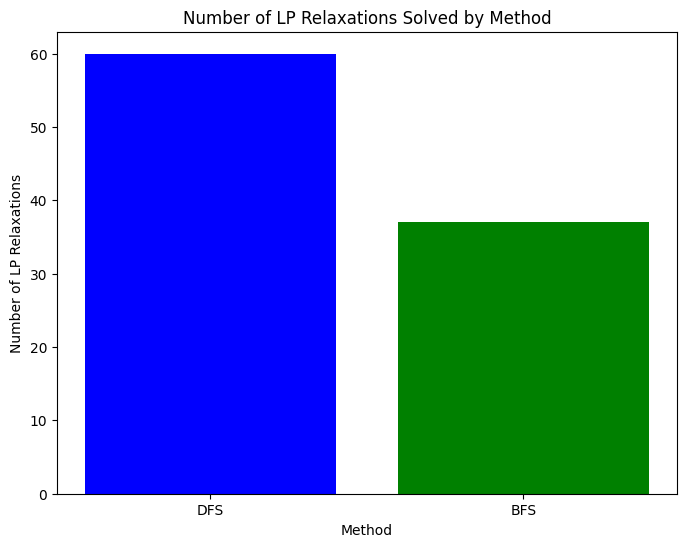

In [178]:
solution_dfs, obj_value_dfs, num_relaxations_dfs = dfs_branch_and_bound(variable_selection_policy=lowest_index_variable)
print(f"DFS - Solution: {solution_dfs}, Objective Value: {obj_value_dfs}, Number of LP relaxations solved: {num_relaxations_dfs}")

solution_bfs, obj_value_bfs, num_relaxations_bfs = bfs_branch_and_bound(variable_selection_policy=lowest_index_variable)
print(f"BFS - Solution: {solution_bfs}, Objective Value: {obj_value_bfs}, Number of LP relaxations solved: {num_relaxations_bfs}")

methods = ["DFS", "BFS"]
num_relaxations = [num_relaxations_dfs, num_relaxations_bfs]

plt.figure(figsize=(8, 6))
plt.bar(methods, num_relaxations, color=['blue', 'green'])
plt.title("Number of LP Relaxations Solved by Method")
plt.xlabel("Method")
plt.ylabel("Number of LP Relaxations")
plt.show()

DFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 59
BFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 38


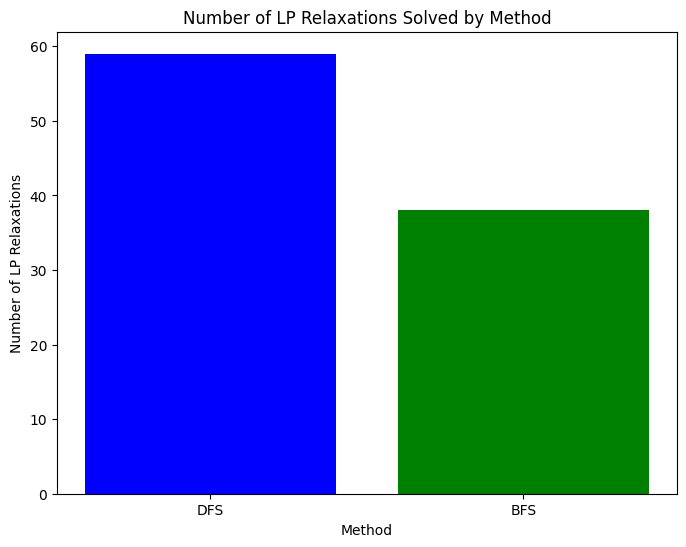

In [179]:
solution_dfs, obj_value_dfs, num_relaxations_dfs = dfs_branch_and_bound(variable_selection_policy=closest_to_half_variable)
print(f"DFS - Solution: {solution_dfs}, Objective Value: {obj_value_dfs}, Number of LP relaxations solved: {num_relaxations_dfs}")

solution_bfs, obj_value_bfs, num_relaxations_bfs = bfs_branch_and_bound(variable_selection_policy=closest_to_half_variable)
print(f"BFS - Solution: {solution_bfs}, Objective Value: {obj_value_bfs}, Number of LP relaxations solved: {num_relaxations_bfs}")

methods = ["DFS", "BFS"]
num_relaxations = [num_relaxations_dfs, num_relaxations_bfs]

plt.figure(figsize=(8, 6))
plt.bar(methods, num_relaxations, color=['blue', 'green'])
plt.title("Number of LP Relaxations Solved by Method")
plt.xlabel("Method")
plt.ylabel("Number of LP Relaxations")
plt.show()

DFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 84
BFS - Solution: [3.0, 6.0, 4.0, 1.0, 1.0, 5.0, 5.0, 3.0, 2.0, 3.0], Objective Value: 207.0, Number of LP relaxations solved: 69


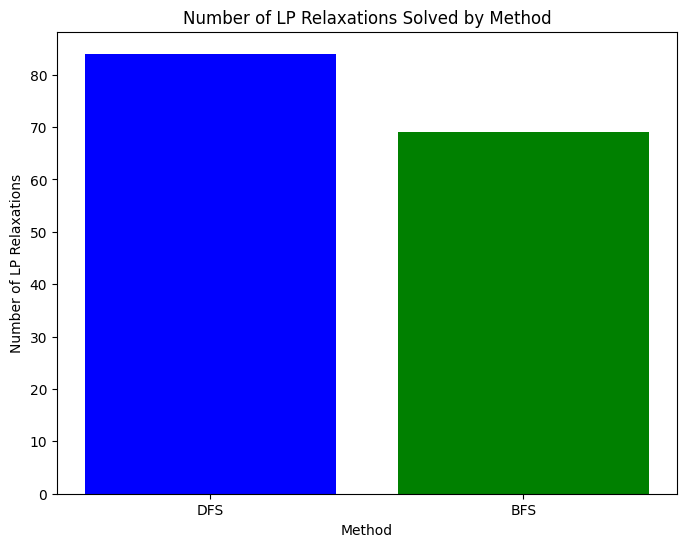

In [180]:
solution_dfs, obj_value_dfs, num_relaxations_dfs = dfs_branch_and_bound(variable_selection_policy=most_constrained_variable)
print(f"DFS - Solution: {solution_dfs}, Objective Value: {obj_value_dfs}, Number of LP relaxations solved: {num_relaxations_dfs}")

solution_bfs, obj_value_bfs, num_relaxations_bfs = bfs_branch_and_bound(variable_selection_policy=most_constrained_variable)
print(f"BFS - Solution: {solution_bfs}, Objective Value: {obj_value_bfs}, Number of LP relaxations solved: {num_relaxations_bfs}")

methods = ["DFS", "BFS"]
num_relaxations = [num_relaxations_dfs, num_relaxations_bfs]

plt.figure(figsize=(8, 6))
plt.bar(methods, num_relaxations, color=['blue', 'green'])
plt.title("Number of LP Relaxations Solved by Method")
plt.xlabel("Method")
plt.ylabel("Number of LP Relaxations")
plt.show()